In [2]:
import numpy as np
import pandas as pd
import os


In [3]:
import skimage as skio
import matplotlib.pyplot as plt 
import matplotlib.animation as animation

In [4]:
from IPython.core.display import display,HTML
display(HTML('<style>.prompt{width: 0px; min-width: 0px; visibility: collapse}</style>'))

#%matplotlib inline%config Completer.use_jedi=False

from ipywidgets import interact, Dropdown, IntSlider
from tqdm import tqdm_notebook


train_acl = pd.read_csv('train-acl.csv', header=None,
                       names=['Case', 'Abnormal'], 
                       dtype={'Case': str, 'Abnormal': np.int64})

train_acl.head()


,Case,Abnormal
0,0000,0
1,0001,1
2,0002,0
3,0003,0
4,0004,0


In [5]:
print(train_acl.shape)


(1130, 2)


In [6]:
train_acl.Abnormal.value_counts(normalize=True)


0    0.815929
1    0.184071
Name: Abnormal, dtype: float64

In [64]:
case = '0004'

mri_coronal = np.load('train/coronal/0004.npy')
mri_axial = np.load('train/axial/0004.npy')
mri_sagittal = np.load('train/sagittal/0004.npy')

print(f'MRI scan on coronal plane: {mri_coronal.shape}')
print(f'MRI scan on axial plane: {mri_axial.shape}')
print(f'MRI scan on sagittal plane: {mri_sagittal.shape}')

MRI scan on coronal plane: (34, 256, 256)
MRI scan on axial plane: (40, 256, 256)
MRI scan on sagittal plane: (32, 256, 256)


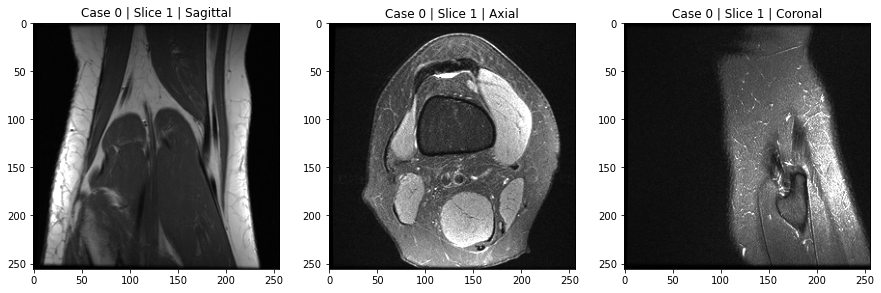

In [8]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

ax1.imshow(mri_coronal[0, :, :], 'gray');
ax1.set_title('Case 0 | Slice 1 | Sagittal');

ax2.imshow(mri_axial[0, :, :], 'gray');
ax2.set_title('Case 0 | Slice 1 | Axial');

ax3.imshow(mri_sagittal[0, :, :], 'gray');
ax3.set_title('Case 0 | Slice 1 | Coronal');

In [9]:
import cv2

In [10]:
#!pip install SimpleITK
import SimpleITK as sitk

In [11]:
print(sitk.__version__)

2.1.0.dev245


median1 = cv2.medianBlur(mri_coronal[0, :, :],3)
median2 = cv2.medianBlur(mri_axial[0, :, :],3)
median3 = cv2.medianBlur(mri_sagittal[0, :, :],3)


filtered_image = sitk.GetImageFromArray(mri_coronal.astype('float32'))
corrector = sitk.N4BiasFieldCorrectionImageFilter()
numberFittingLevels = 4
maskImage = sitk.OtsuThreshold(filtered_image, 0, 1, 200)
output = corrector.Execute(filtered_image, maskImage)

filtered_image = sitk.GetImageFromArray(mri_coronal.astype('float32'))

def bias_correction(inputImage):
    Image = sitk.GetImageFromArray(inputImage.astype('float32'))
    corrector = sitk.N4BiasFieldCorrectionImageFilter()
    corrector.SetMaximumNumberOfIterations([10])
    numberFittingLevels = 4
    maskImage = sitk.OtsuThreshold(Image, 0, 1, 200)
    output = corrector.Execute(Image, maskImage)
    return output 


import time

t0 = time.perf_counter()
bias_c = bias_correction(mri_coronal[0,:,:])
t1 = time.perf_counter()
print(t1-t0)
bias_a = bias_correction(mri_axial[0,:,:])
bias_s = bias_correction(mri_sagittal[0,:,:])

slice_c = sitk.GetArrayViewFromImage(bias_c)
slice_a = sitk.GetArrayViewFromImage(bias_a)
slice_s = sitk.GetArrayViewFromImage(bias_s)


fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

ax1.imshow(slice_c, 'gray');
ax1.set_title('Case 0 | Slice 1 | Sagittal');

ax2.imshow(slice_a, 'gray');
ax2.set_title('Case 0 | Slice 1 | Axial');

ax3.imshow(slice_s, 'gray');
ax3.set_title('Case 0 | Slice 1 | Coronal');

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

ax1.imshow(median1, 'gray');
ax1.set_title('Case 0 | Slice 1 | Sagittal Median');

ax2.imshow(median2, 'gray');
ax2.set_title('Case 0 | Slice 1 | Axial Median');

ax3.imshow(median3, 'gray');
ax3.set_title('Case 0 | Slice 1 | Coronal Median');

if ("SITK_NOSHOW" not in os.environ):
    sitk.Show(bias_c, "N4 Corrected")


In [12]:
train_path = 'train/'

def load_one_stack(case, data_path=train_path, plane='coronal'):
    fpath = '{}/{}/{}.npy'.format(data_path, plane, case)
    return np.load(fpath)

def load_stacks(case, data_path=train_path):
    x = {}
    planes = ['coronal', 'sagittal', 'axial']
    for i, plane in enumerate(planes):
        x[plane] = load_one_stack(case, plane=plane)
    return x

def load_cases(train=True, n=None):
    assert (type(n) == int) and (n < 1250)
    if train:
        case_list = pd.read_csv('train-acl.csv', names=['case', 'label'], header=None,
                               dtype={'case': str, 'label': np.int64})['case'].tolist()        
    else:
        case_list = pd.read_csv('valid-acl.csv', names=['case', 'label'], header=None,
                               dtype={'case': str, 'label': np.int64})['case'].tolist()        
    cases = {}
    
    if n is not None:
        case_list = case_list[:n]
        
    for case in tqdm_notebook(case_list, leave=False):
        x = load_stacks(case)
        cases[case] = x
    return cases

cases = load_cases(n=100)

ipykernel_launcher:27: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/100 [00:00<?, ?it/s]

In [13]:
class KneePlot():
    def __init__(self, cases, figsize=(15, 5)):
        self.cases = cases
        
        self.planes = {case: ['coronal', 'sagittal', 'axial'] for case in self.cases}
    
        self.slice_nums = {}
        for case in self.cases:
            self.slice_nums[case] = {}
            for plane in ['coronal', 'sagittal', 'axial']:
                self.slice_nums[case][plane] = self.cases[case][plane].shape[0]

        self.figsize = figsize
        
    def _plot_slices(self, case, im_slice_coronal, im_slice_sagittal, im_slice_axial):
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=self.figsize)
        
        ax1.imshow(self.cases[case]['coronal'][im_slice_coronal, :, :], 'gray')
        ax1.set_title(f'MRI slice {im_slice_coronal} on coronal plane')
        
        ax2.imshow(self.cases[case]['sagittal'][im_slice_sagittal, :, :], 'gray')
        ax2.set_title(f'MRI slice {im_slice_sagittal} on sagittal plane')
        
        ax3.imshow(self.cases[case]['axial'][im_slice_axial, :, :], 'gray')
        ax3.set_title(f'MRI slice {im_slice_axial} on axial plane')
        
        plt.show()
    
    def draw(self):
        case_widget = Dropdown(options=list(self.cases.keys()),
                               description='Case'
                              
                              )
        case_init = list(self.cases.keys())[0]


        slice_init_coronal = self.slice_nums[case_init]['coronal'] - 1        
        slices_widget_coronal = IntSlider(min=0, 
                                          max=slice_init_coronal, 
                                          value=slice_init_coronal // 2, 
                                          description='Coronal')
        
        slice_init_sagittal = self.slice_nums[case_init]['sagittal'] - 1        
        slices_widget_sagittal = IntSlider(min=0,
                                           max=slice_init_sagittal,
                                           value=slice_init_sagittal // 2,
                                           description='Sagittal'
                                          )
        
        slice_init_axial = self.slice_nums[case_init]['axial'] - 1        
        slices_widget_axial = IntSlider(min=0,
                                        max=slice_init_axial,
                                        value=slice_init_axial // 2,
                                        description='Axial'
                                       )
        
        def update_slices_widget(*args):
            slices_widget_coronal.max = self.slice_nums[case_widget.value]['coronal'] - 1
            slices_widget_coronal.value = slices_widget_coronal.max // 2
            
            slices_widget_sagittal.max = self.slice_nums[case_widget.value]['sagittal'] - 1
            slices_widget_sagittal.value = slices_widget_sagittal.max // 2
            
            slices_widget_axial.max = self.slice_nums[case_widget.value]['axial'] - 1
            slices_widget_axial.value = slices_widget_axial.max // 2
    
        
        case_widget.observe(update_slices_widget, 'value')
        interact(self._plot_slices,
                 case=case_widget, 
                 im_slice_coronal=slices_widget_coronal, 
                 im_slice_sagittal=slices_widget_sagittal, 
                 im_slice_axial=slices_widget_axial
                )
    
    def resize(self, figsize): 
        self.figsize = figsize

In [14]:
knee = KneePlot(cases)
knee.draw()

interactive(children=(Dropdown(description='Case', options=('0000', '0001', '0002', '0003', '0004', '0005', '0…

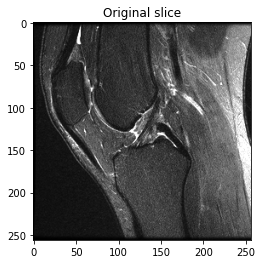

In [15]:
plt.title('Original slice')
plt.imshow(mri_sagittal[15,:,:], cmap='gray')

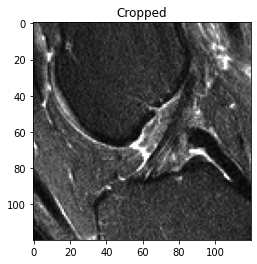

In [65]:
acl = mri_sagittal[15,60:180,60:180]
plt.title('Cropped')
plt.imshow(acl, cmap='gray')

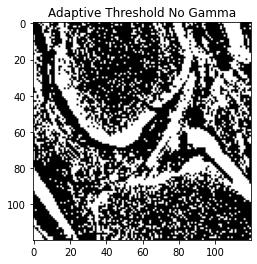

In [66]:
# OTSU without Gamma
otsu = cv2.adaptiveThreshold(acl,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY_INV,51,10)
#otsu = 255 - otsu
plt.title('Adaptive Threshold No Gamma')
plt.imshow(otsu, cmap='gray')
plt.show()

In [67]:
from skimage.segmentation import active_contour
#import morphsnakes

In [68]:
def visual_callback_2d(background, fig=None):
    """
    Returns a callback than can be passed as the argument `iter_callback`
    of `morphological_geodesic_active_contour` and
    `morphological_chan_vese` for visualizing the evolution
    of the levelsets. Only works for 2D images.
    Parameters
    ----------
    background : (M, N) array
        Image to be plotted as the background of the visual evolution.
    fig : matplotlib.figure.Figure
        Figure where results will be drawn. If not given, a new figure
        will be created.
    Returns
    -------
    callback : Python function
        A function that receives a levelset and updates the current plot
        accordingly. This can be passed as the `iter_callback` argument of
        `morphological_geodesic_active_contour` and
        `morphological_chan_vese`.
    """

    # Prepare the visual environment.
    if fig is None:
        fig = plt.figure()
    fig.clf()
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.imshow(background, cmap=plt.cm.gray)

    ax2 = fig.add_subplot(1, 2, 2)
    ax_u = ax2.imshow(np.zeros_like(background), vmin=0, vmax=1)
    plt.pause(0.001)

    def callback(levelset):

        if ax1.collections:
            del ax1.collections[0]
        ax1.contour(levelset, [0.5], colors='r')
        ax_u.set_data(levelset)
        fig.canvas.draw()
        plt.pause(0.001)

    return callback

In [69]:
# bresenham function is the accepted answer of SO's post https://stackoverflow.com/questions/23930274/list-of-coordinates-between-irregular-points-in-python
def bresenham(x0, y0, x1, y1):
   points = []
   dx = abs(x1 - x0)
   dy = abs(y1 - y0)
   x, y = x0, y0
   sx = -1 if x0 > x1 else 1
   sy = -1 if y0 > y1 else 1
   if dx > dy:
      err = dx / 2.0
      while x != x1:
         points.append((x, y))
         err -= dy
         if err < 0:
            y += sy
            err += dx
         x += sx
   else:
      err = dy / 2.0
      while y != y1:
         points.append((x, y))
         err -= dx
         if err < 0:
            x += sx
            err += dy
         y += sy
   points.append((x, y))

   return points


def strel_line(length, degrees):
   if length >= 1:
      theta = degrees * np.pi / 180
      x = round((length - 1) / 2 * np.cos(theta))
      y = -round((length - 1) / 2 * np.sin(theta))
      points = bresenham(-x, -y, x, y)
      points_x = [point[0] for point in points]
      points_y = [point[1] for point in points]
      n_rows = int(2 * max([abs(point_y) for point_y in points_y]) + 1)
      n_columns = int(2 * max([abs(point_x) for point_x in points_x]) + 1)
      strel = np.zeros((n_rows, n_columns))
      rows = ([point_y + max([abs(point_y) for point_y in points_y]) for point_y in points_y])
      columns = ([point_x + max([abs(point_x) for point_x in points_x]) for point_x in points_x])
      idx = []
      for x in zip(rows, columns):
         idx.append(np.ravel_multi_index((int(x[0]), int(x[1])), (n_rows, n_columns)))
      strel.reshape(-1)[idx] = 1

   return strel

In [72]:
strel45 = strel_line(5, 45).astype(np.uint8)
strel60 = strel_line(5, 60).astype(np.uint8)
strel135 = strel_line(5, 60).astype(np.uint8)
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
kernel_ones = np.ones((3,3),np.uint8)
print(strel45)
print(strel60)
print(strel135)

[[0 0 1]
 [0 1 0]
 [1 0 0]]
[[0 0 1]
 [0 1 0]
 [0 1 0]
 [1 0 0]
 [1 0 0]]
[[0 0 1]
 [0 1 0]
 [0 1 0]
 [1 0 0]
 [1 0 0]]


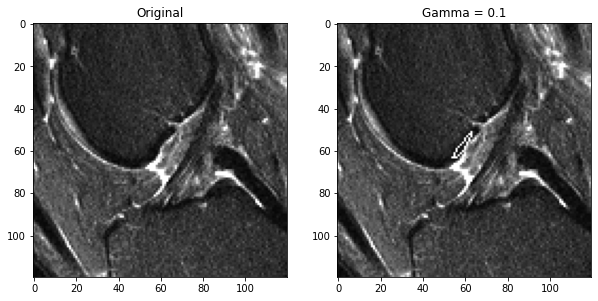

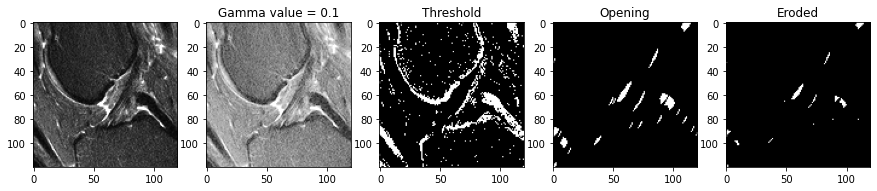

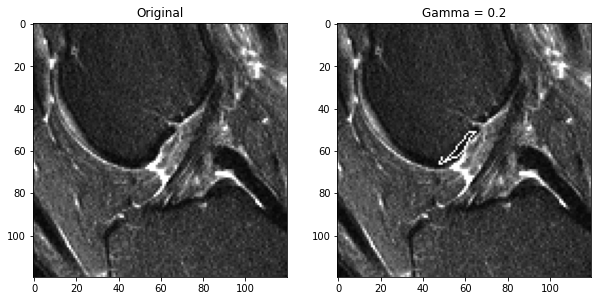

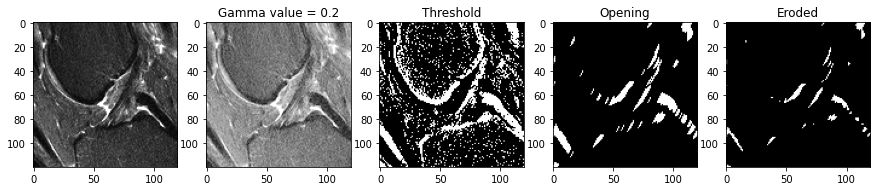

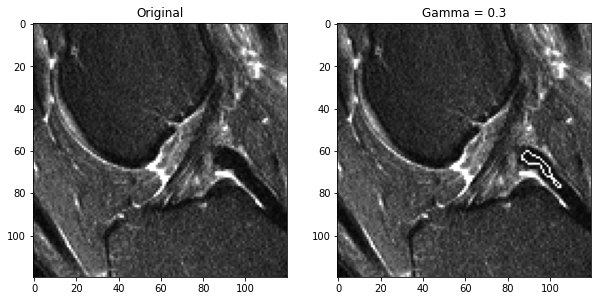

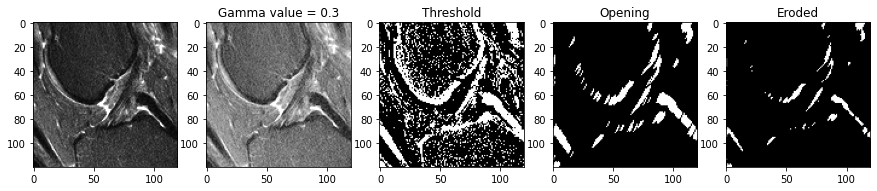

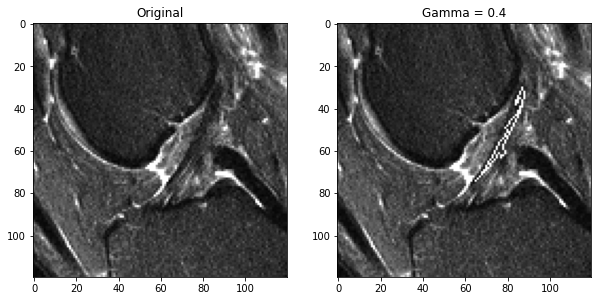

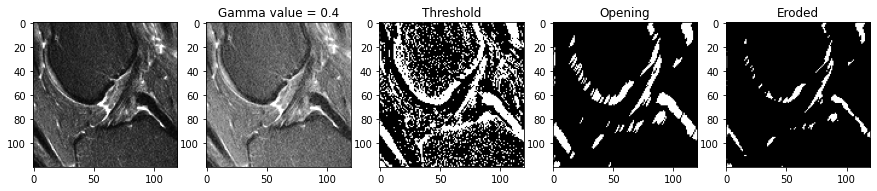

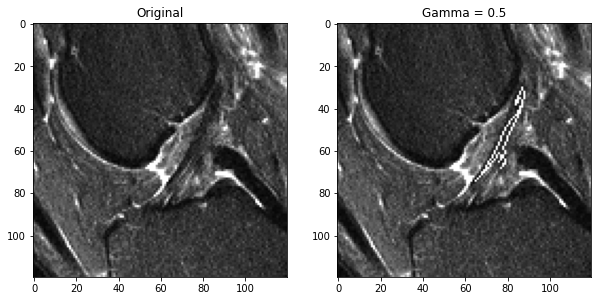

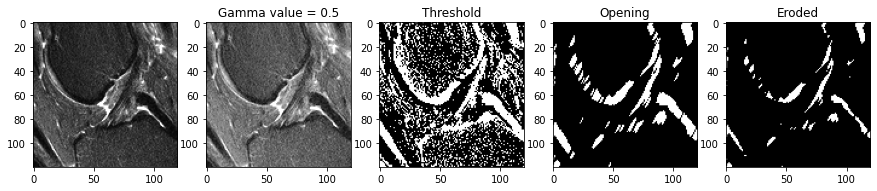

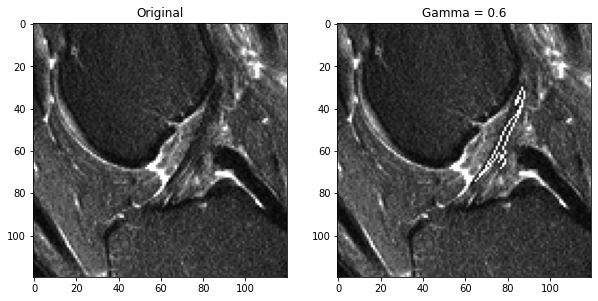

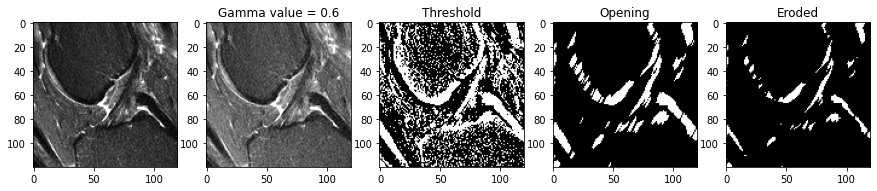

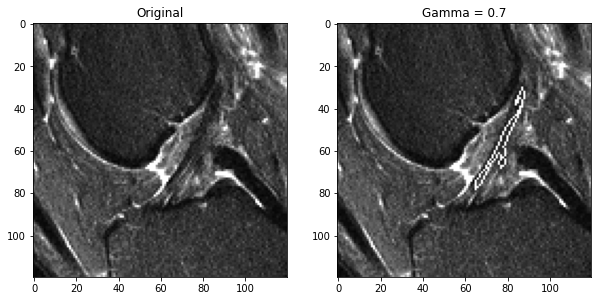

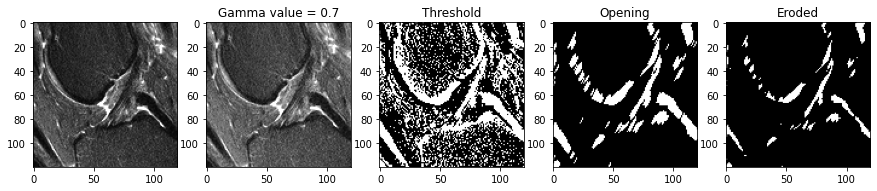

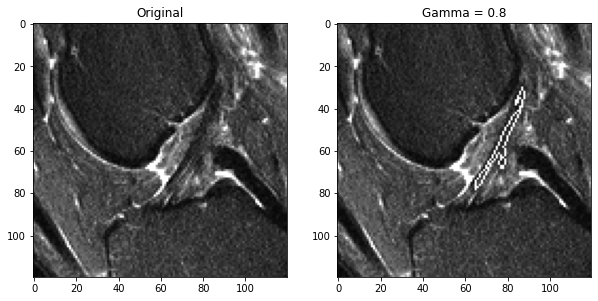

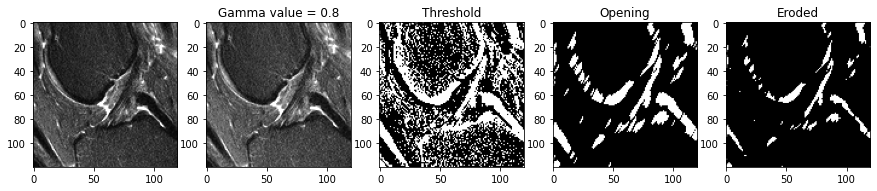

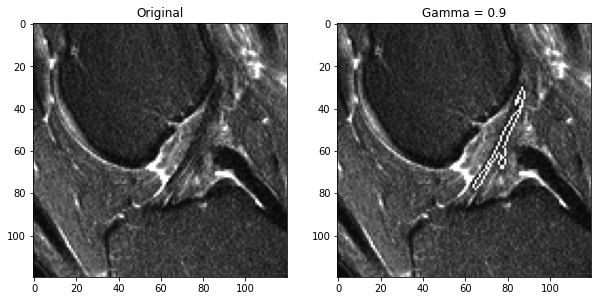

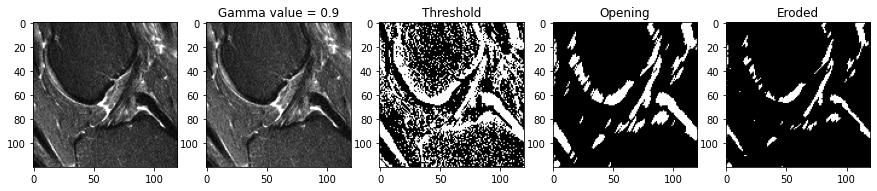

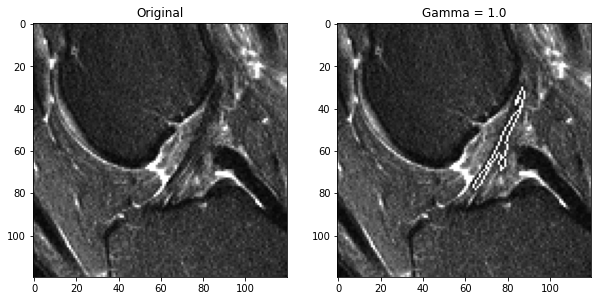

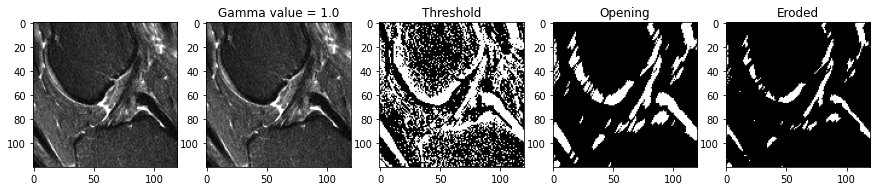

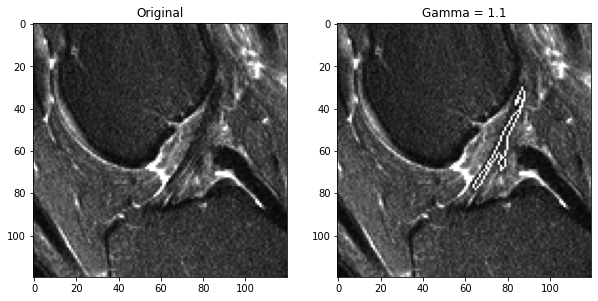

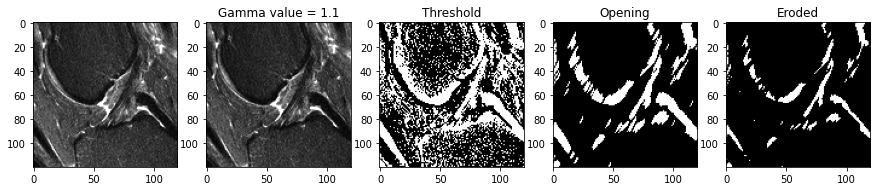

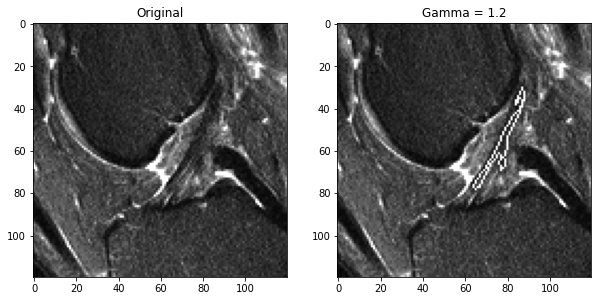

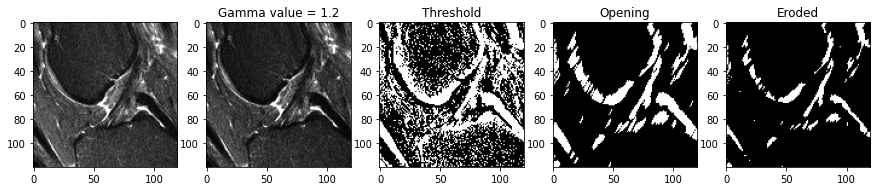

In [73]:

#for gamma in [0.5, 0.75, 1.2, 1.5]:
for gamma in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2]:
      
    # Apply gamma correction.
    gamma_corrected = np.array(255*(acl / 255) ** gamma, dtype = 'uint8')

    #otsu = cv2.threshold(gamma_corrected,0,255,cv2.THRESH_OTSU)[1]
    otsu = cv2.adaptiveThreshold(gamma_corrected,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY_INV,51,10)
    #otsu = otsu - 255
    otsu = np.uint8(otsu) 
    #print(otsu)

    opening = cv2.morphologyEx(otsu, cv2.MORPH_OPEN, kernel, iterations = 1)

    opening = cv2.morphologyEx(otsu, cv2.MORPH_OPEN, strel45, iterations = 1)
    opening = cv2.morphologyEx(opening, cv2.MORPH_OPEN, strel135, iterations = 1)
    opening = cv2.morphologyEx(opening, cv2.MORPH_OPEN, strel60, iterations = 1)
    #opening = cv2.morphologyEx(otsu, cv2.MORPH_OPEN, kernel, iterations = 1)
    
    eroded = cv2.erode(opening, strel60,iterations = 1)
    closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel_ones, iterations = 1)

    #ls = morphsnakes.circle_level_set(otsu.shape, (80, 80), 20)
    #callback = visual_callback_2d(otsu)

    """morphsnakes.morphological_chan_vese(otsu, iterations=100,
                               init_level_set=ls,
                               smoothing=3, lambda1=1, lambda2=1,
                               iter_callback=callback)"""

    output = cv2.connectedComponentsWithStats(eroded, labels=None)
    (numLabels, labels, stats, centroids) = output
    area = stats[:, cv2.CC_STAT_AREA]
    max_label, max_size = max([(i, stats[i, cv2.CC_STAT_AREA]) for i in range(1, numLabels)], key=lambda x: x[1])
    img2 = np.zeros(labels.shape)
    img2 = (labels == max_label).astype("uint8")
    contours, hierarchy = cv2.findContours(img2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    image = acl.copy()
    image = cv2.drawContours(image, contours, -1, (255, 0, 0), thickness=1)
    #print(max(contours))
    fig = plt.figure(figsize=[10,10])
    plt.subplot(1,2,1)
    plt.title('Original')
    plt.imshow(acl, cmap='gray')
    plt.subplot(1,2,2)
    plt.title('Gamma = {}'.format(gamma))
    plt.imshow(image, cmap='gray')
    plt.show()
    for i in range(0, numLabels):
    	# if this is the first component then we examine the
        # *background* (typically we would just ignore this
        # component in our loop)
        """if i == 0:
            text = "examining component {}/{} (background)".format(
                i + 1, numLabels)
        # otherwise, we are examining an actual connected component
        else:"""
        #text = "examining component {}/{}".format( i + 1, numLabels)
        # print a status message update for the current connected
        # component
        #print("[INFO] {}".format(text))
        # extract the connected component statistics and centroid for
        # the current label
        x = stats[i, cv2.CC_STAT_LEFT]
        y = stats[i, cv2.CC_STAT_TOP]
        w = stats[i, cv2.CC_STAT_WIDTH]
        h = stats[i, cv2.CC_STAT_HEIGHT]
        area = stats[i, cv2.CC_STAT_AREA]
        (cX, cY) = centroids[i]
        #print('A=',area)

        output = eroded.copy()
        #print('Copied...')
        cv2.rectangle(output, (x, y), (x + w, y + h), (0, 255, 0), 3)
        cv2.circle(output, (int(cX), int(cY)), 4, (0, 0, 255), -1)

        # construct a mask for the current connected component by
        # finding a pixels in the labels array that have the current
        # connected component ID
        componentMask = (labels == i).astype("uint8") * 255
        # show our output image and connected component mask
        """if area > 100:
            #plt.imshow(output, cmap='gray')
            #plt.show()
            print('A=',area)
            plt.imshow(componentMask, cmap='gray')
            plt.show()"""

    
    fig = plt.figure(figsize=[15,15])
    # Save edited images.
    plt.subplot(1,5,1)
    plt.imshow(acl, cmap='gray')
    plt.subplot(1,5,2)
    plt.title('Gamma value = {}'.format(gamma))
    plt.imshow(gamma_corrected, cmap='gray')
    plt.subplot(1,5,3)
    plt.title('Threshold')
    plt.imshow(otsu, cmap='gray')
    plt.subplot(1,5,4)
    plt.title('Opening')
    plt.imshow(opening, cmap='gray')
    plt.subplot(1,5,5)
    plt.title('Eroded')
    plt.imshow(eroded, cmap='gray')
    plt.show()

# 005 not good
